# Convert CVAT format to yolo

In [1]:
import xmltodict
import json
from collections import namedtuple
from tqdm import tqdm
from tqdm.notebook import tqdm as ntqdm
from os.path import join, isdir, isfile
from os import makedirs
from shutil import copy2
import cv2
from utils import Segment, Bbox, ImageAnnot
from pathlib import Path
from random import shuffle
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
cd ..

/home/masoud/Desktop/projects/volleyball_analytics


/home/masoud/anaconda3/envs/p/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
from src.ml.yolo.players.detection import PlayerDetector
from src.ml.yolo.players.pose_estimation import PoseEstimator
from src.utilities.utils import Meta

In [5]:
cap = cv2.VideoCapture('data/raw/videos/test/videos/11_short.mp4')
cap.set(1, 400)
status, frame = cap.read()

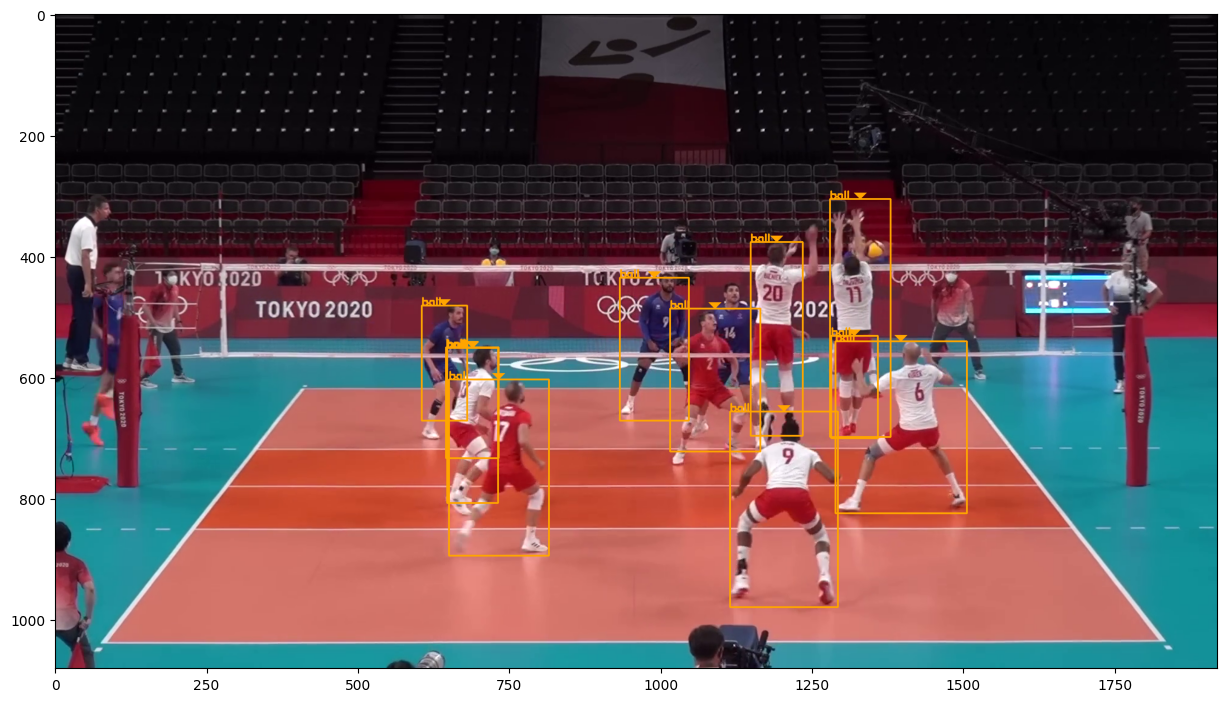

In [6]:
# p = "im.png"
# img = cv2.imread(p)
# img = cv2.cvtColor(img, 4)
img = cv2.cvtColor(frame, 4)

court_coordinates = {
    "main_zone": [
        [410, 620],
        [1500, 620],
        [1830, 1040],
        [80, 1040]
    ],
    "front_zone": [
        [170, 715],
        [1750, 715],
        [1850, 850],
        [80, 850]
    ]
}


player_detector = PlayerDetector(court_dict=court_coordinates)
kp_detector = PoseEstimator()

player_bboxes = player_detector.detect_all(img)
player_bboxes = player_detector.filter(player_bboxes, keep=12)
player_kps = kp_detector.detect(img)

f1 = img.copy()
f2 = img.copy()

f1 = player_detector.draw(f1, player_bboxes, use_marker=True, color=Meta.orange)

up_kps = [kp for kp in player_kps if kp.is_facing_to_camera]
down_kps = [kp for kp in player_kps if not kp.is_facing_to_camera]

# f2 = kp_detector.draw(f2, player_kps, use_marker=True)
# f2 = kp_detector.draw(f2, up_kps, use_marker=True, color=(255, 0, 0))
# f2 = kp_detector.draw(f2, down_kps, use_marker=True, color=(0, 0, 255))


imshow(f1)
plt.show()
# imshow(f2)
# plt.show()

In [ ]:
player_kps

In [ ]:
up_kps

In [ ]:
down_kps

In [ ]:
vid = cv2.VideoCapture('/home/masoud/Desktop/projects/volleyball_analytics/data/raw/videos/test/videos/11.mp4')
vid.set(1, 200)
status, img = vid.read()
img = cv2.cvtColor(img, 4)

# cv2.circle(img, (80, 1035), 10, (255, 0, 0), -1) # left down
# cv2.circle(img, (410, 615), 10, (255, 0, 0), -1) # left up
# cv2.circle(img, (1500, 620), 10, (255, 0, 0), -1) # right up
# cv2.circle(img, (1830, 1035), 10, (255, 0, 0), -1) # right down

# # 1/3

# cv2.circle(img, (170, 715), 10, (0, 255, 0), -1) # left top
# cv2.circle(img, (1750, 715), 10, (0, 255, 0), -1) # right top
# cv2.circle(img, (1850, 850), 10, (0, 255, 0), -1) # right down
# cv2.circle(img, (80, 850), 10, (0, 255, 0), -1) # left down

# # center line
# cv2.circle(img, (285, 780), 10, (0, 0, 255), -1) # left
# cv2.circle(img, (1625, 780), 10, (0, 0, 255), -1) # right


imshow(img)


## Utility functions

In [ ]:
def _json_object_hook(d): 
    return namedtuple('X', d.keys())(*d.values())

def json2obj(data): 
    return json.loads(open(data).read(), object_hook=_json_object_hook)

def xml2object(xml: str, output_path: str):
    with open(xml) as xml_file:
        data_dict = xmltodict.parse(xml_file.read())     
        json_data = json.dumps(data_dict)
        with open(output_path, "w") as json_file:
            json_file.write(json_data)
    f = open(output_path).read()
    f = f.replace("@", '')
    f = f.replace("#", "")
    with open(output_path, 'w') as file:
        file.write(f)
    return json2obj(output_path)


def get_labels(data: namedtuple):
    # Extract labels from converted object
    return [l.name for l in data.annotations.meta.task.labels[0]]

def get_images_with_annots(data: namedtuple):
    return [item for item in data.annotations.image if 'polygon' in item._asdict() or 'box' in item._asdict()]

def filter_some_annots(imgs_list: list):
    temp = []
    for img in ntqdm(imgs_list):
        try:
            if img.box.label == 'set' and img.box.attribute.text == 'fore-arms':
                continue
            elif img.box.label == 'receive' and img.box.attribute.text == 'setting-dig':
                continue
            else:
                temp.append(img)
        except:
            temp.append(img)
    return temp

def get_video_name(data: namedtuple):
    return data.annotations.meta.task.name

## Prepare input/output files and paths

In [ ]:
# base_path = '../input/videos/train/'
# xmls = Path(base_path) / "annotations/6_classes/
# xmls = xmls.glob('*.xml')

# def process_xml(xmls):
#     all_img_annots = []
#     for input_xml in xmls:
#         data = xml2object(input_xml, 'data.json')
#         labels = get_labels(data)
#         img_annots = get_images_with_annots(data)
#         img_annots = filter_some_annots(img_annots)
#         video_file = get_video_name(data)
#         video_path = Path(base_path) / video_file
#         assert input_xml.is_file()
#         assert video_path.is_file()

#         cap = cv2.VideoCapture(video_path.as_posix())
#         assert cap.isOpened(), "video file not opened...."
#         yield cap, img_annots

In [ ]:
!pwd

In [ ]:
base_path = '/home/masoud/Desktop/projects/volleyball_analytics/data/raw/videos/train'
input_xml = Path(base_path) / "annotations/6_classes/2.xml"
data = xml2object(input_xml, 'data.json')

labels = get_labels(data)
img_annots = get_images_with_annots(data)
img_annots = filter_some_annots(img_annots)
video_file = get_video_name(data)
video_path = Path(base_path) / video_file
assert input_xml.is_file()
assert video_path.is_file()

cap = cv2.VideoCapture(video_path.as_posix())
assert cap.isOpened(), "video file not opened...."

## Loop over annotations and creating images/labels

In [ ]:
labels2ix = {label: i for i, label in enumerate(labels)}
labels2ix

In [ ]:
train_img_dir = "data/images/train"
val_img_dir = "data/images/val"

train_label_dir = "data/detection/labels/train"
val_label_dir = "data/detection/labels/val"

seg_train_label_dir = "data/segment/labels/train"
seg_val_label_dir = "data/segment/labels/val"


for i in [train_img_dir, val_img_dir, train_label_dir, val_label_dir, 
          seg_train_label_dir, seg_val_label_dir]:
    makedirs(i, exist_ok=True)

shuffle(img_annots)
train_size = int(len(img_annots) * 0.9)

In [ ]:
!ls

In [ ]:
for idx, img_annot in enumerate(ntqdm(img_annots)):
    img_annot = img_annot._asdict()
    ball_segments = []
    ball_bboxes = []
    txt_segment = ''
    polygons = []
    txt_boxes = ''
    temp = []
    
    # handle frame extraction
    frame_id = int(img_annot['id'])
    cap.set(1, frame_id)
    _, frame = cap.read()
    img_h, img_w, _ = frame.shape
    
    # Extract ball info (segmentation mask points and bounding box)
    if 'polygon' in img_annot:
        polygons = [img_annot['polygon']] if not isinstance(img_annot['polygon'], list) else img_annot['polygon']
        
        for j, p in enumerate(polygons):
            polygon = p.points
            polygon_label = p.label
            points = [int(float(item)) for item in polygon.replace(';', ' ').replace(',', ' ').split(' ')]

            ball_segment = Segment(points, labels2ix[polygon_label])
            ball_bbox = ball_segment.get_bbox()
            
            txt_segment += ball_segment.segment_to_yolo(img_w, img_h)
            if j != len(polygons)-1:
                txt_segment += '\n'
            ball_bboxes.append(ball_bbox)

    # Handle bounding boxes (add ball bounding box as well).
    
    if 'box' in img_annot:
        if isinstance(img_annot['box'], list):
            boxes = img_annot['box']
        else:
            boxes = [img_annot['box']]
    else:
        boxes = []

    for box in boxes:
        b = Bbox((int(float(box.xtl)), int(float(box.ytl)), int(float(box.xbr)), int(float(box.ybr))), labels2ix[box.label])
        temp.append(b)

    boxes = temp.copy()
    if len(ball_bboxes):
        boxes.extend(ball_bboxes)
    
    # for p in boxes
    sorted(boxes, key=lambda x: x.label, reverse=True)

    if not len(boxes):
        continue
    
    # Generate yolo segment/bbox label...
    for ii, box in enumerate(boxes):
        if box.label in (0,5):
            continue
        yolo_fmt = box.to_yolo(img_w, img_h)
        if ii != len(boxes) - 1:
            yolo_fmt += '\n'
        txt_boxes += yolo_fmt
    
    # Save image/label file in specified path
    file_stem = f"{video_path.stem}-frame_{frame_id}"

    if idx < train_size:
        img_path = f'{train_img_dir}/{file_stem}.png'
        seg_path = f'{seg_train_label_dir}/{file_stem}.txt'
        det_path = f'{train_label_dir}/{file_stem}.txt'
    else:
        img_path = f'{val_img_dir}/{file_stem}.png'
        seg_path = f'{seg_val_label_dir}/{file_stem}.txt'
        det_path = f'{val_label_dir}/{file_stem}.txt'
    
    cv2.imwrite(img_path, frame)
    with open(det_path, 'w') as det_file:
        det_file.write(txt_boxes)

    with open(seg_path, 'w') as seg_file:
        seg_file.write(txt_segment)